In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import pylab
import itertools
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import numpy as np
import xgboost as xgb
import pickle
import DataReader 
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
%matplotlib inline

## Define Helper Functions

In [53]:
def add_delays(df, window):
    lags = pd.ewma(df,window)
    diffs = df-lags

    lags.columns = [x+'.ewma' for x in df.columns]
    diffs.columns = [x+'.diff' for x in df.columns]
    return pd.concat([df,lags,diffs], axis=1)

def get_estimator(estimator):
    if estimator == 'booster':
        e = xgb.XGBModel(objective='reg:linear',
                                 max_depth=11,
                                 subsample=0.5,
                                 colsample_bytree=0.5,
                                 learning_rate=0.1,
                                 n_estimators=500,
                                 silent=1,
                                 seed=42)
                
    elif estimator == 'xtrees':
        e = ExtraTreesRegressor(n_estimators=700,
                                      random_state=0,
                                      min_samples_leaf=20,
                                      n_jobs=-1)
    elif estimator == 'rf':
        e=RandomForestRegressor(n_estimators=500,
                                        random_state=1,
                                        min_samples_leaf=10,
                                        n_jobs=-1)
    return e

def get_trained_estimator(estimator, X, y):
    e = get_estimator(estimator)
    e.fit(X,y)
    return e

def get_all_models(estimators, power_lines, X_list, train_all, feature_dict=None, feat_no=None):
    models = {}
    for w in power_lines:
        models[w] = []
        features = list(X_list[0].columns)
        if feature_dict is not None:
            features=feature_dict[w]
        for estimator in estimators:
            for X in X_list:
                e=get_trained_estimator(estimator,
                                         X[features[:feat_no]].astype(float),
                                         train_all.loc[X.index][w].astype(float))
                print estimator, w
                models[w].append(e)
    return models

## Load Massaged Data (from DataReader)

In [27]:
r = DataReader.PdData()
years = range(1,4)
train = dict(zip(years, 
                 [r.massaged_data(x, hourly=True).dropna() for x in years]))
train_all = pd.concat(train.values(), axis=0).sort_index()
test = r.massaged_data(None, no_power_sub=True, hourly=True).dropna()

In [28]:
features=[x for x in test.columns if "NPWD" not in x]

In [29]:
X_train_all = train_all[features]
X_train_3 = train[3][features]
X_test = test[features]

In [30]:
X_train_all = add_delays(X_train_all, 4)
X_train_3 = add_delays(X_train_3, 4)
X_test = add_delays(X_test, 4)

In [31]:
power_lines=[x for x in test.columns if "NPWD" in x]

## Get important features (according to extra trees estimator) for each power line

In [49]:
try:
    # Check if pickle is already there
    importances = pickle.load( open( "immportances.pickle", "rb" ) ) 
except IOError:
    # Get Extra Trees models, one per power line, just to see feature importances
    models=get_all_models(['xtrees'], power_lines, [X_train_all[features]], train_all)
    imp_per_w = {}
    
    # Get importances
    for i in power_lines:
        imp = models[i][0].feature_importances_
        imp_per_w[i] = []
        indices = np.argsort(imp)[::-1]
        for f in range(X_train_all[features].shape[1]):
            imp_per_w[i].append(list(X_train_all.columns)[indices[f]])
            
    # Sorted Feature importances are dumped to a pickle file
    pickle.dump( imp_per_w, open( "importances.pickle", "wb" ) )
    importances = imp_per_w

xtrees NPWD2372
xtrees NPWD2401
xtrees NPWD2402
xtrees NPWD2451
xtrees NPWD2471
xtrees NPWD2472
xtrees NPWD2481
xtrees NPWD2482
xtrees NPWD2491
xtrees NPWD2501
xtrees NPWD2531
xtrees NPWD2532
xtrees NPWD2551
xtrees NPWD2552
xtrees NPWD2561
xtrees NPWD2562
xtrees NPWD2691
xtrees NPWD2692
xtrees NPWD2721
xtrees NPWD2722
xtrees NPWD2742
xtrees NPWD2771
xtrees NPWD2791
xtrees NPWD2792
xtrees NPWD2801
xtrees NPWD2802
xtrees NPWD2821
xtrees NPWD2851
xtrees NPWD2852
xtrees NPWD2871
xtrees NPWD2872
xtrees NPWD2881
xtrees NPWD2882


## Inspect top features

In [50]:
pd.DataFrame.from_dict(importances).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
NPWD2372,pair9,asc_des,ttp,height_change,APSF,AMMM,pair_c_9,MAPO,conjuction,solarconstantmars,D4PNPO,MPER,sunmarsearthangle_deg2,pair11,pair4,ut,UMBRA_season,pair_c_7,pair0,pair7
NPWD2401,eclipseduration_min,solarconstantmars,ut,sunmarsearthangle_deg2,sunmarsearthangle_deg,pair_c_12,pair12,APSF,occultationduration_min,ATMB,MOCE,pair11,ATTT,pair4,AACF,MPER,UMBRA_season,AAAA,pair17,pair_c_17
NPWD2402,APSF,pair13,pair12,sz,pair4,pair11,D4PNPO,pair_c_12,ATTT,PENS,eclipseduration_min,MOCE,asc_des,UMBRA_time,sunmarsearthangle_deg,sunmarsearthangle_deg2,ut,MOCS,PENUMBRA_time,pair_c_13
NPWD2451,sunmarsearthangle_deg,solarconstantmars,UMBRA_season,ut,sunmarsearthangle_deg2,conjuction,eclipseduration_min,pair2,ttp,ASXX,pair_c_3,EARTH,occultationduration_min,MAPO,asc_des,ATMB,pair_c_17,UMBRA_time1,AVVV,height_change
NPWD2471,height_change,pair_c_7,pair14,pair15,pair16,pair17,pair_c_1,pair_c_2,pair_c_3,pair_c_4,pair_c_5,pair_c_6,pair_c_8,pair12,pair_c_9,pair_c_10,pair_c_11,pair_c_12,pair_c_13,pair_c_14
NPWD2472,ut,pair_c_3,pair_c_15,sunmarsearthangle_deg2,solarconstantmars,pair15,pair2,pair3,sunmarsearthangle_deg,occultationduration_min,eclipseduration_min,pair_c_10,SCMN,pair4,AACF,AAAA,pair_c_13,pair11,AMMM,UMBRA_season
NPWD2481,pair9,AAAA,AACF,pair0,asc_des,ut,pair1,sunmarsearthangle_deg2,AMMM,pair_c_9,solarconstantmars,D4PNPO,sunmarsearthangle_deg,pair_c_15,pair_c_16,pair16,pair15,occultationduration_min,AOOO,ATMB
NPWD2482,eclipseduration_min,solarconstantmars,sunmarsearthangle_deg2,ut,sunmarsearthangle_deg,pair_c_12,pair12,APSF,occultationduration_min,ATMB,ATTT,pair11,MOCE,pair4,AACF,AAAA,pair17,MPER,UMBRA_season,AMMM
NPWD2491,pair9,ttp,AHHH,pair_c_9,AMMM,height_change,solarconstantmars,pair_c_7,sunmarsearthangle_deg2,pair7,conjuction,pair0,pair_c_3,ut,MAPO,pair4,pair11,eclipseduration_min,AAAA,ATTT
NPWD2501,pair1,pair11,pair4,pair9,pair_c_9,pair0,pair_c_1,pair13,ATMB,eclipseduration_min,AHHH,des_len,pair2,AOOO,occultationduration_min,sx,EARTH,AACF,AAAA,solarconstantmars


## Train models, xgboost and extra-trees, against the 40 top features

In [56]:
models=get_all_models(['xtrees','booster'], power_lines, [X_train_all], train_all, importances, 40)

xtrees NPWD2372
booster NPWD2372
xtrees NPWD2401
booster NPWD2401
xtrees NPWD2402
booster NPWD2402
xtrees NPWD2451
booster NPWD2451
xtrees NPWD2471
booster NPWD2471
xtrees NPWD2472
booster NPWD2472
xtrees NPWD2481
booster NPWD2481
xtrees NPWD2482
booster NPWD2482
xtrees NPWD2491
booster NPWD2491
xtrees NPWD2501
booster NPWD2501
xtrees NPWD2531
booster NPWD2531
xtrees NPWD2532
booster NPWD2532
xtrees NPWD2551
booster NPWD2551
xtrees NPWD2552
booster NPWD2552
xtrees NPWD2561
booster NPWD2561
xtrees NPWD2562
booster NPWD2562
xtrees NPWD2691
booster NPWD2691
xtrees NPWD2692
booster NPWD2692
xtrees NPWD2721
booster NPWD2721
xtrees NPWD2722
booster NPWD2722
xtrees NPWD2742
booster NPWD2742
xtrees NPWD2771
booster NPWD2771
xtrees NPWD2791
booster NPWD2791
xtrees NPWD2792
booster NPWD2792
xtrees NPWD2801
booster NPWD2801
xtrees NPWD2802
booster NPWD2802
xtrees NPWD2821
booster NPWD2821
xtrees NPWD2851
booster NPWD2851
xtrees NPWD2852
booster NPWD2852
xtrees NPWD2871
booster NPWD2871
xtrees NPW

## Make predictions

In [97]:
submission=pd.read_csv('power-prediction-sample-2014-04-14_2016-03-01.csv')
submission.index=test.index
predictions  = {}
for w in power_lines:
    predictions[w] = test[['ut']]
    for idx, est in enumerate(models[w]):
        m = "model_%d"%idx
        predictions[w][m]=est.predict(X_test[importances[w][:40]].astype(float))
    submission[w] = predictions[w][[x for x in predictions[w].columns if 'model' in x]].mean(axis=1)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [98]:
for i in submission.columns:
    submission.loc[submission[i] < 0,i] = 0
   


In [104]:
submission.loc[list(test.loc[pd.to_datetime(submission['ut_ms'], unit='ms'), 'conjuction']), "NPWD2551"] =0 


## Visual Inspection

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1bf98ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1d108310>], dtype=object)

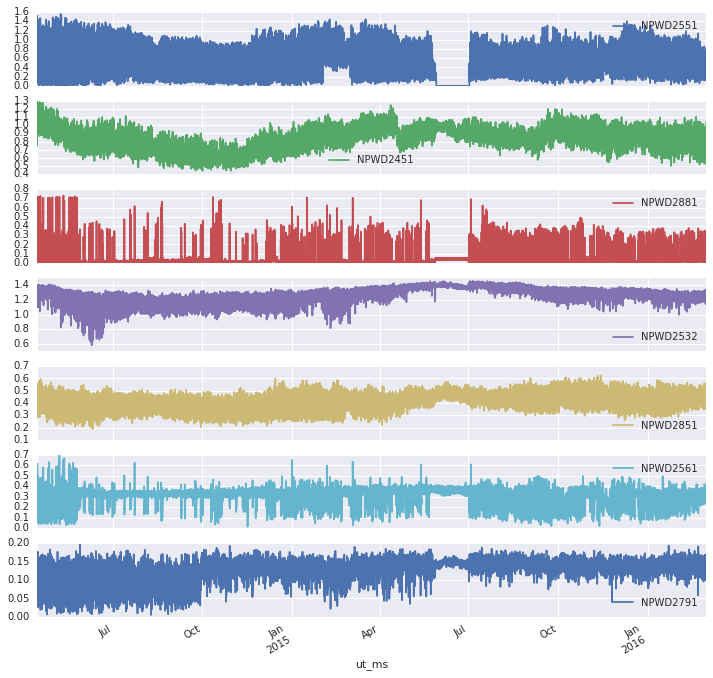

In [103]:
submission[['NPWD2551', 'NPWD2451', 'NPWD2881', 'NPWD2532', 'NPWD2851', 'NPWD2561', 'NPWD2791']].plot(subplots=True, figsize=(12,12))